# XGBoost with automatic cross-validated optimization

**Example using the xgb_auto function in the EasyMLR module**

The **xgb_auto** function in the EasyMLR module automatically finds the optimum set of cross-validated hyper-parameters and then outputs the fitted regression model and summary statistics using XGBoost with optuna.

The **xgb_auto** function standardizes the X input by default. 

This example shows how to check the cross-validation of the model with independent training and testing data subsets before fitting the final model with all of the data.

#### Example data set

This example uses the diabetes data described in the following tutorial by sklearn:

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py


Before running this notebook, first install the EasyMLR module in your environment, if it is not already installed, using the following line in the next cell:

In [1]:
# !pip install git+https://github.com/gjpelletier/EasyMLR.git --upgrade

## Read X and y from the sklearn diabetes data set

In [2]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True, as_frame=True)

## Split X and y into cross-validation train and test subsets

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the model with the training data subset

In the next step, we will automatically find the best cross-validated hyper-parameters for XGBoost using optuna. Then we will fit the model using the training data with the best parameters. 

After this training step is completed, proceed to the next step to check how well the predictions from the training data match the predictions using the testing data. 

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting XGBRegressor model with best parameters, please wait ...
XGBRegressor statistics of fitted model in model_outputs['stats']:

| Statistic   |   XGBRegressor |
|:------------|---------------:|
| r-squared   |       0.745027 |
| RMSE        |      39.3614   |
| n_samples   |     353        |

Done
Time elapsed: 366.62 sec



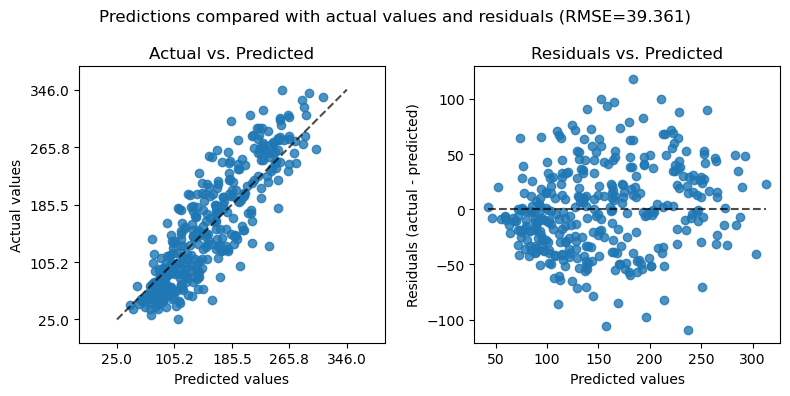

In [4]:
from EasyMLR import xgb_auto
train_model, train_output = xgb_auto(X_train, y_train,
    # [min, max] range of params that are optimized by optuna
    random_state= 42,                 # random seed for reproducibility
    n_trials= 50,                     # number of optuna trials
    learning_rate= [0.01, 0.3],       # step size shrinkage (also called eta)
    max_depth= [3, 10],               # maximum depth of a tree
    min_child_weight= [1, 10],        # minimum sum of instance weight (hessian) needed in a child
    subsample= [0.5, 1],              # fraction of samples used for training each tree
    colsample_bytree= [0.5, 1],       # fraction of features used for each tree
    gamma= [0, 10],                   # finimum loss reduction to make a split
    reg_lambda= [0, 10],              # L2 regularization term on weights
    alpha= [0, 10],                   # L1 regularization term on weights
    n_estimators= [100, 1000]         # number of boosting rounds (trees)
    )

## Test the model with the testing data subset

In the next step we will check how well the predictions from fitted model match samples from the testing data. To standardize the testing data we will use the same scaler that was used to standardized the training data to avoid data leakage between the training and testing data.

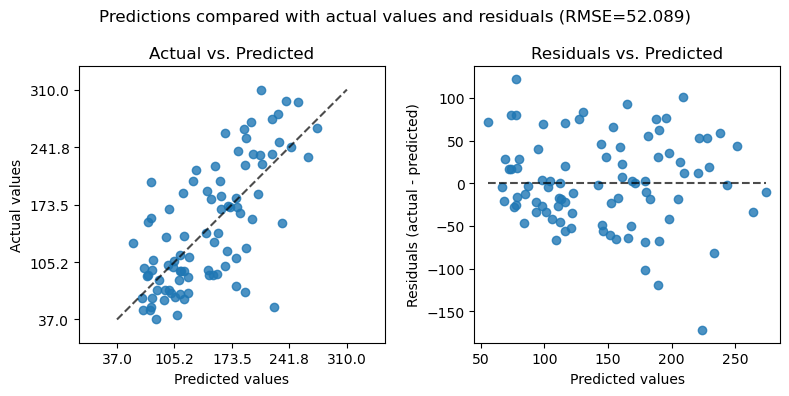

In [5]:
from EasyMLR import plot_predictions_from_test
fig = plot_predictions_from_test(train_model, X_test, y_test, scaler=train_output['scaler'])
fig.savefig("XGBRegressor_predictions_test.png", dpi=300)

## Final fit of the model using all of the X and y data

In the next step we will use the best parameters from the training model to fit the model using all of the X and y data.

Fitting XGBRegressor model, please wait ...

XGBRegressor statistics of fitted model in model_outputs['stats']:

| Statistic   |   XGBRegressor |
|:------------|---------------:|
| r-squared   |       0.724001 |
| RMSE        |      40.4554   |
| n_samples   |     442        |

Done
Time elapsed: 0.90 sec



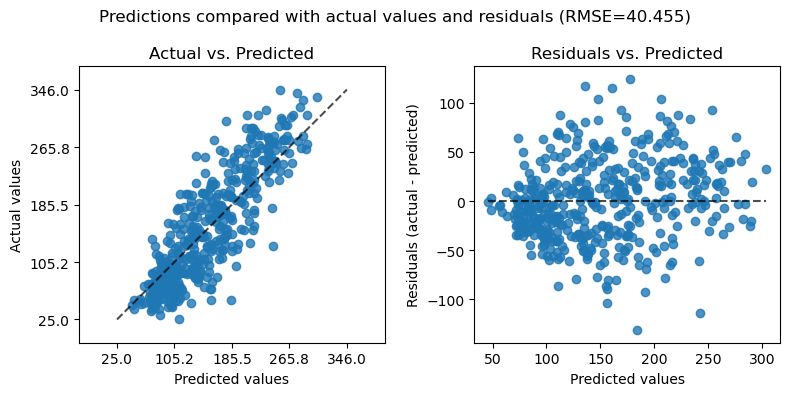

In [6]:
from EasyMLR import xgb
final_model, final_output = xgb(X, y, **train_output['best_params'])

## Display the results of the hyperparameter optimization

The results of the optuna optimization study were saved in the previous step when the model was trained with the training data subset. The output dictionary that we called **train_output** in that step contains a key named **optuna_study** which contains the results of the optimized optuna study. 

In the next step we will use the **show_optuna** function of EasyMLR to display the results of the optimized cross-validated optuna study to show the selected optimum values for the hyperparameters, the optimization history, and the relationships between the hyperparameters and their importance for the scoring criteria.

Best parameters:

learning_rate: 0.0508578580413352
max_depth: 3
min_child_weight: 7
subsample: 0.6444343850650998
colsample_bytree: 0.5403317102892631
gamma: 5.618338422432841
reg_lambda: 9.720261275688237
alpha: 0.9769710608190643
n_estimators: 193

Best score: -57.03323712236848



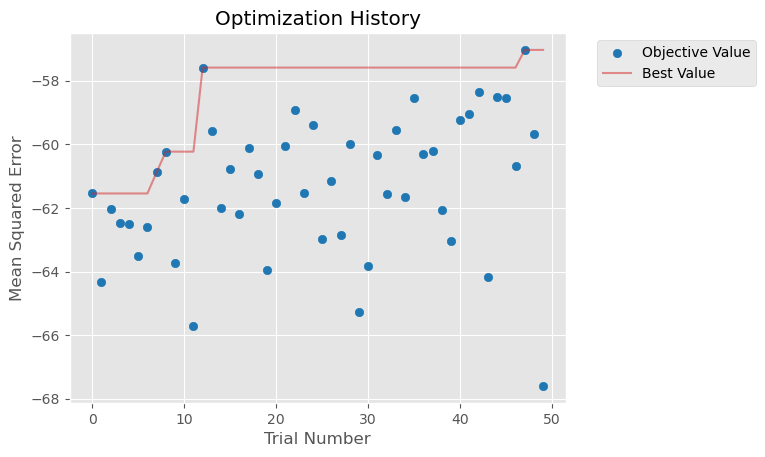

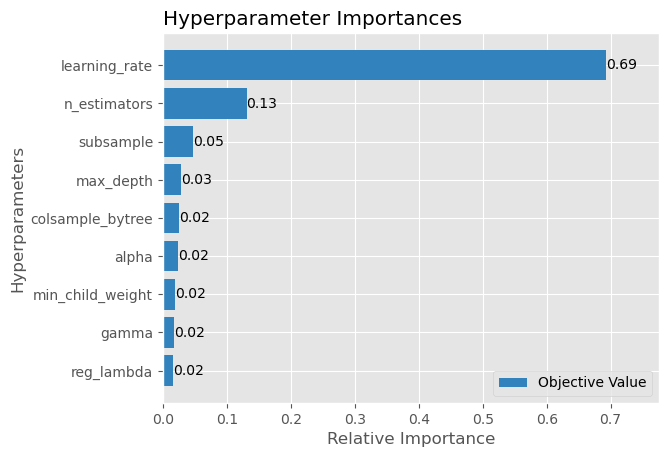

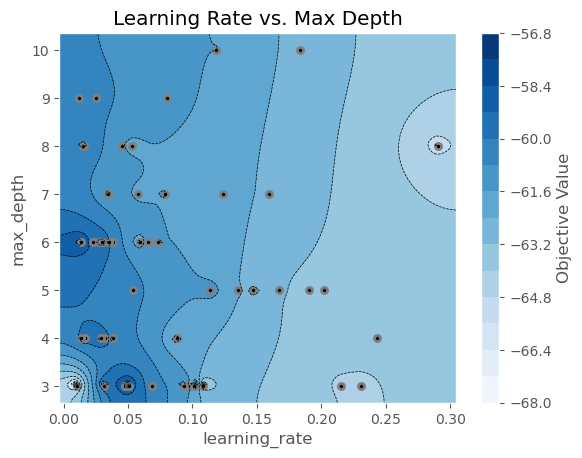

In [7]:
from EasyMLR import show_optuna
show_optuna(train_output['optuna_study'])

## User instructions

In [2]:
from EasyMLR import xgb_auto
help(xgb_auto)

Help on function xgb_auto in module EasyMLR:

xgb_auto(X, y, **kwargs)
    Autocalibration of XGBoost XGBRegressor hyper-parameters
    Beta version

    by
    Greg Pelletier
    gjpelletier@gmail.com
    04-June-2025

    REQUIRED INPUTS (X and y should have same number of rows and
    only contain real numbers)
    X = dataframe of the candidate independent variables
        (as many columns of data as needed)
    y = dataframe of the dependent variable (one column of data)

    OPTIONAL KEYWORD ARGUMENTS
    **kwargs (optional keyword arguments):
        verbose= 'on' (default) or 'off'
        standardize= True (default) or False where
            True: standardize X using sklearn.preprocessing StandardScaler
            False: do not standardize X (only used if X is already standardized)
        gpu= True (default) or False to autodetect if the computer has a gpu and use it
        n_trials= 50,                     # number of optuna trials
        n_splits= 5,                   